**Steps involved :**

**Data Collection**
* Preprocessing the Data
* Splitting the data(spectrum) into separate filter lengths
* Passing the filters through a CNN for reconstruction of the spectrum
* We can construct spectrum from just an image
---
**For the redshift part :**

* Soften the data using Savitzky Golay filter
* Construct the XGBoost model from scratch or from library
* Predict the redshift
* Compare the results

**Step 1 : Data collection :**
The cnn model we are using almost require 700 datasets. Which include 4 filters of the galaxy and it's spectrum respectively.But Downloading such mass of a dataset manually isn't possible and we couldn't find a ready set online. SO we had to create an automation software to mimic the manual entry and download.

* For the automation task we employed a library named Selenium. And the site from which the data is being downloaded is SDSS sky survey. The Automation process includes, Entering into the website and navigating to find the form regarding the SpaceID of the object of interest. The program then fills the form from one of the ID's stored in a CSV file tailored by us selecting suitable galaxies.
* After navigating, a new page is loaded to download the filters of the galaxy in a corrected frame.


---


* The file is then downloaded and stored in the following format:
* Data/galaxy/galaxy_id_filter.fits.bz2/galaxy_id_spectrum.fits.bz2

---

* Then the files from which in format of fits.bz2 is unpacked to .fits format.

In [ ]:
# Importing the base modules
import pandas as pd #Used for reading the data from CSV
import numpy as np
import os
import shutil
import glob
import time
import bz2
from colorist import Color
import datetime

# Import the web automation library
from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
#Folder monitoring 
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
# Intitializing the options to an empty function to prevent errors
options = Options()

# Enter the SDSS data collection webpage
 # and m = n
class Id_collection:
    def __init__(self,n_points,csv_file):
        self.n_points = n_points
        self.csv_file = csv_file
    def get_Ids(self):
        file = pd.read_csv(self.csv_file)
        ids = file["specobj_id"].head(self.n_points).tolist()
        SpaceIds = []
        for i in range(len(ids)):
            SpaceIds.append(int(ids[i][1:-1]))
        return SpaceIds
    def url_const_im(self,SpaceIds):
        urls = []
        for i in range(len(SpaceIds)):
            urls.append(f"http://cas.sdss.org/dr18/VisualTools/explore/summary?sId={SpaceIds[i]}")
        return urls
    def url_const_sp(self,SpaceIds):
        urls = []
        for i in range(len(SpaceIds)):
            urls.append(f"https://cas.sdss.org/dr18/VisualTools/explore/fitsspec?spec={SpaceIds[i]}")
        return urls
    def is_present(driver,url):
        element = driver.find_element(By.XPATH,'//*[@id="explore"]/div[3]/div/div/text()')
        if element:
            return False
        else:
            return True
class Unpack_move:
    def unpack_fits(file_path):
        # Create a unique filename based on the current timestamp
        timestamp = datetime.datetime.now().strftime("%M%S")
    
        # Check if the filename contains parentheses
        if '(' in os.path.basename(file_path) and ')' in os.path.basename(file_path):
            fits_file_n = f"{file_path[:-11]}_{timestamp}.fits"  # Adjust as necessary based on your naming convention
        else:
            fits_file_n = f"{file_path[:-8]}_{timestamp}.fits"  # Adjust as necessary based on your naming convention
    
    # Unpack the .bz2 file
        with bz2.open(file_path, "rb") as file:
            with open(fits_file_n, "wb") as fits_file:
                fits_file.write(file.read())
    
        return fits_file_n


    def move_rename_images(file_name, id):
        collection_unit = os.path.join("C:/Users/HP/Desktop/Python/data", f"Galaxy_{id}/images")
        os.makedirs(collection_unit, exist_ok=True)
        shutil.move(file_name, os.path.join(collection_unit, os.path.basename(file_name)))

    def move_rename_spectrum(file_name, id):
        collection_unit = os.path.join("C:/Users/HP/Desktop/Python/data", f"Galaxy_{id}/spectrum")
        os.makedirs(collection_unit, exist_ok=True)
        shutil.move(file_name, os.path.join(collection_unit, os.path.basename(file_name)))

    def move_rename_images(file_name,id):
        collection_unit = os.path.join("C:/Users/HP/Desktop/Python/data",f"Galaxy_{id}/images")
        os.makedirs(collection_unit,exist_ok=True)
        shutil.move(file_name,os.path.join(collection_unit),os.path.basename(file_name))
    def move_rename_spectrum(file_name,id):
        collection_unit = os.path.join("C:/Users/HP/Desktop/Python/data",f"Galaxy_{id}/spectrum")
        os.makedirs(collection_unit,exist_ok=True)
        shutil.move(file_name,os.path.join(collection_unit),os.path.basename(file_name))

# Initializing monitoring systems
class NewFileHandler(FileSystemEventHandler):
    def on_created(self, event):
        if not event.is_directory:
            if os.path.basename(event.src_path).endswith(".fits.bz2"):
                print(f"{event.src_path} is {Color.GREEN}downloaded")

def monitor_folder(folder_path):
    event_handler = NewFileHandler()
    observer = Observer()
    observer.schedule(event_handler, folder_path, recursive=False)
    observer.start()
    print(f"{Color.GREEN}Started monitoring folder: {Color.CYAN}{folder_path}")
    try:
        while True:
            time.sleep(1)  
    except KeyboardInterrupt:
        pass
        observer.stop()  # Stop the observer when interrupted (Ctrl+C)
        #print("Stopped monitoring.")
    observer.join()
    

    
# Intitialize the Id collection class
Id_collection = Id_collection(504,"./optical_search_430636.csv")
spaceIds = Id_collection.get_Ids()
#print(spaceIds)
url_collection = Id_collection.url_const_im(spaceIds)
#print(url_collection)
url_collection_spectrum = Id_collection.url_const_sp(spaceIds)
#print(url_collection_spectrum)

# Now we have the urls for all n_points number of galxies in a list
# Next part is to access the url and download the filters and spectrum

def navigate_to_fits(url):
    driver = webdriver.Firefox()
    driver.get(url)

    # Wait until the "FITS" link becomes clickable
    wait = WebDriverWait(driver, 15)
    fits_link = wait.until(EC.element_to_be_clickable((By.PARTIAL_LINK_TEXT, 'FITS')))
    fits_link.click()

    # Switch to the new tab
    driver.switch_to.window(driver.window_handles[1])

    # Download all filters in corrected frames
    filters = ["u", "g", "r", "i", "z"]

    # Collect and click all download links without waiting
    for filter in filters:
        wait_time = WebDriverWait(driver, 3.5)
        download_link = wait_time.until(EC.presence_of_element_located((By.LINK_TEXT, filter)))
        download_link.click()
        time.sleep(0.01)  # Click the link directly to start download

    # Wait for the downloads to complete
    downloads_path = "C:/Users/HP/Downloads"

    # Check for the number of downloaded files
    while True:
        file_list = glob.glob(os.path.join(downloads_path, "*.bz2"))
        
        if len(file_list) >= 5:  # Check if at least 5 files have been downloaded
            print(f"5 files downloaded {Color.GREEN}Successfully")
            break

        time.sleep(1)
    time.sleep(0.5)

    driver.quit()  # Close the browser window

def navigate_to_spectrum(url):
    driver = webdriver.Firefox()
    driver.get(url)
    wait = WebDriverWait(driver,2.5)
    folder_path = "C:/Users/HP/Downloads"
    event_handler = NewFileHandler()
    observer = Observer()
    observer.schedule(event_handler, folder_path, recursive=False)
    observer.start()
    print(f"{Color.GREEN}Started monitoring folder: {Color.CYAN}{folder_path}")

    spectrum_link = wait.until(EC.element_to_be_clickable((By.PARTIAL_LINK_TEXT,"Download")))
    spectrum_link.click()
    time.sleep(1)
    driver.quit()
    observer.stop()
    print(f"Spectrum downloaded {Color.GREEN}Successfully")
    observer.join()  
#running a loop
downloads_path = "C:/Users/HP/Downloads"
for i in range(100):
    print(f"Started downloading Galaxy{i+1}_{spaceIds[i]}")
    navigate_to_fits(url_collection[i])
    file_list = glob.glob(os.path.join(downloads_path,"*.bz2"))
    file_list.sort(key = os.path.getmtime,reverse=True)
    file_list = file_list[0:5]
    folder_id = spaceIds[i]
    for j in range(len(file_list)):
        ftbu = file_list[j]
        unpacked_file = Unpack_move.unpack_fits(ftbu)
        #moving to folder
        Unpack_move.move_rename_images(unpacked_file,folder_id)
        print(f"{Color.GREEN}Moved {unpacked_file} into Galaxy{folder_id}/images ")
    navigate_to_spectrum(url_collection_spectrum[i])
    spec_file_list = glob.glob(os.path.join(downloads_path,"*fits"))
    spec_file_list.sort(key = os.path.getmtime,reverse=True)
    spec_file_list = spec_file_list[0]
    Unpack_move.move_rename_spectrum(spec_file_list,folder_id)
    print(f"{Color.GREEN}Moved {spec_file_list} into Galaxy{folder_id}/spectrum ")


Started downloading Galaxy1_299489677444933632


KeyboardInterrupt: 

**Data Visuailization**
Once the data is downloaded. We can now visualize the data we got using matplotlib. Once plotted the graph,we can observe that our galaxy is not present in the center of the image, but embedded somewhere in the image. Hence our duty now is to isolate the galaxy.

---

**Isolation of the galaxy we need :**
To isolate the galaxy we needed we need to get the cordinates of the required galaxy first. And from the SDSS imaging survey we can observe that the maximum hieght and width of the image is 20 degrees each. Now for the cordinates part : We can extract the Re and dec values from the webpage containing the galaxy's Id in the folder. Using scipy and few image processing modules we can crop the image to isolate the galaxy we need.

---

**Next few steps :**
Upon cropping the galaxy in to isolation, We can now observe that the cropping and zooming the image the clarity of the image is really pixalated, using this as is might propagate errors through the CNN models. So we need to clean the image using a module called *Galmask*. This can reduce errors and etc. For further cleaning we can smooth out the edges and image using guassian filters.

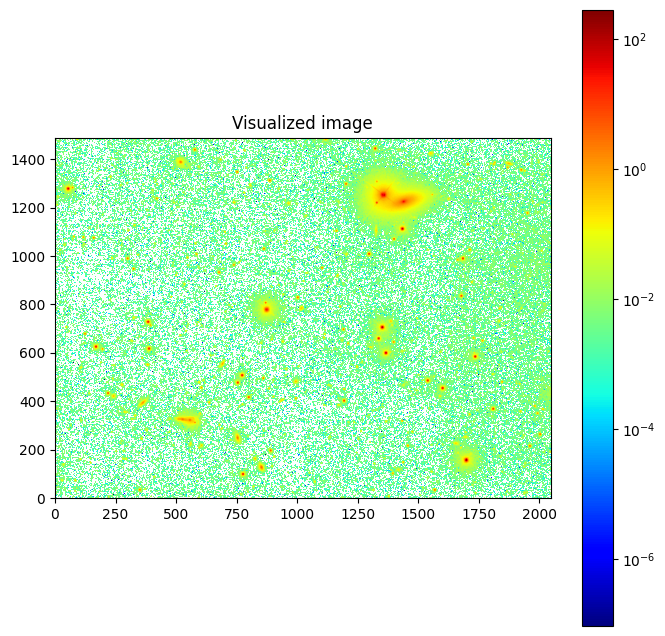

In [7]:
#Using matplottlib to visualize the data acquired

# Visualizing the data
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import numpy as np
# Load the image
image_data = fits.getdata('C:/Users/HP/Desktop/Python/data/Galaxy_299518814503069696/images/frame-i-001239-3-0174._5522.fits')# Replace with your file path

plt.figure(figsize=(8, 8))
plt.imshow(image_data, origin='lower',cmap = 'jet',norm=LogNorm())
plt.title('Visualized image')
plt.colorbar()
plt.show()

Once visualized we can observe that the required galaxy is embedded somewhere in the image. We have to Isolate the galaxy now on. If we know the RA and Dec of your galaxy, we can convert them into pixel coordinates using WCS (World Coordinate System) in Python. This will help us locate the approximate center of your galaxy in the image. Hence we can now crop the image.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '22/03/99' to '1999-03-22''. [astropy.wcs.wcs]


RA, Dec: (146.71421, -1.041304)
Pixel coordinates: x=134.54484660833566, y=1098.5109071086565
Cropping bounds: x_min=79, x_max=189, y_min=1043, y_max=1153
Adjusted cropping bounds: x_min=79, x_max=189, y_min=1043, y_max=1153


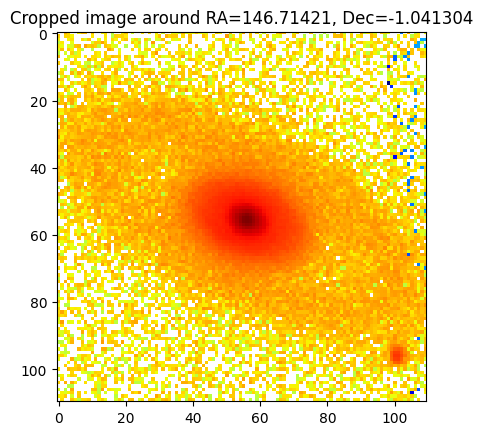

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2
import numpy as np
import matplotlib.pyplot as plt


def isolate_galaxy(file_name, ra, dec, size_pixels_x=110, size_pixels_y=110, show=False):
    """
    Isolate and crop the image around thae given RA and Dec in pixel-based size.

    Parameters:
    - file_name : str
        The file name of the galaxy image.
    - ra : float
        Right Ascension of the galaxy in degrees.
    - dec : float
        Declination of the galaxy in degrees.
    - size_pixels_x : int
        The width of the cropped region in pixels (default is 100 pixels).
    - size_pixels_y : int
        The height of the cropped region in pixels (default is 100 pixels).
    - show : bool
        If True, shows the cropped image. Defaults to False.
    
    Returns:
    - cropped_image : 2D numpy array
        The cropped image data.
    """
    try:
        with fits.open(file_name) as hdul:
            # Extract the WCS information
            wcs = WCS(hdul[0].header)
            image_data = hdul[0].data  # Image data

            if not wcs.is_celestial:
                raise ValueError("The object is not celestial.")
            
            # Create a SkyCoord object for the galaxy
            coord = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')

            # Convert RA, Dec to pixel coordinates
            x_pixel, y_pixel = wcs.world_to_pixel(coord)

            # Debug output
            print(f"RA, Dec: ({ra}, {dec})")
            print(f"Pixel coordinates: x={x_pixel}, y={y_pixel}")

            # Calculate the cropping bounds based on pixel values
            x_min = int(x_pixel - size_pixels_x / 2)
            x_max = int(x_pixel + size_pixels_x / 2)
            y_min = int(y_pixel - size_pixels_y / 2)
            y_max = int(y_pixel + size_pixels_y / 2)

            # Debug output for cropping bounds
            print(f"Cropping bounds: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")

            # Ensure the bounds are within the image dimensions
            x_min, x_max = max(0, x_min), min(image_data.shape[1], x_max)
            y_min, y_max = max(0, y_min), min(image_data.shape[0], y_max)

            # Debug output after adjusting the bounds
            print(f"Adjusted cropping bounds: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")

            # Crop the image
            cropped_image = image_data[y_min:y_max, x_min:x_max]


            # Show the cropped image if 'show' is True
            if show:
                plt.imshow(cropped_image, cmap='jet',norm=LogNorm())
                plt.title(f"Cropped image around RA={ra}, Dec={dec}")
                plt.show()

            return cropped_image

    except Exception as e:
        raise ValueError(f"An error occurred: {e}")
    
cropped_image = isolate_galaxy("C:/Users/HP/Desktop/Python/data/Galaxy_299489677444933632/images/frame-i-000756-1-0206._2435.fits",146.71421,-1.041304,show=True)



**Extracting RA and Dec from a Spectrum FITS File**

This notebook explains how to extract **RA (Right Ascension)** and **Dec (Declination)** values from a **FITS** file, typically used in astronomy for storing image and spectral data.

**Prerequisites**

Make sure you have the **Astropy** library installed. If not, you can install it using:

```bash
pip install astropy


In [ ]:
# Extracting the Ra and Dec values from spectrum file for isolation of galaxy
from astropy.io import fits

def extract_Ra_Dec(file_name):
    """
    Extracts RA and Dec from the header of an SDSS spectrum FITS file.
    
    Parameters:
    - fits_file : str
        The path to the spectrum FITS file.
    
    Returns:
    - ra : float
        The Right Ascension of the galaxy in degrees.
    - dec : float
        The Declination of the galaxy in degrees.
    """

    try:

        with fits.open(file_name) as file:
            data = file[0].header

            ra = data.get("RA")
            dec = data.get("DEC")

            if ra is not None and dec is not None:
                return ra, dec
            else:
                raise ValueError(f"Ra and dec not found in the file")
            
    except Exception as e:
        raise ValueError(f"An error has occured {e}")        

**Once the galaxy is isolated :**

We can denoise it using one of many methods including :
 *  Using Galmask
 *  Using contour softening
 *  Passive denoising (Gaussian Filter)

---

Now we can try using one of these methods but using *Galmask* and then progressively using Passive denoising might yeild better results. To essentially use the *Galmask* module we need to License the module. Some insights into the module revealed that It is in the research paper published by BITS pilani,Goa. Now upon further inspection we found it is in MIT license. So proper use might not get us in trouble. But downloading the module has got issues related due to outdated versions of numpy and scipy. Hence we did have to copy the entire git repository including licencse. 

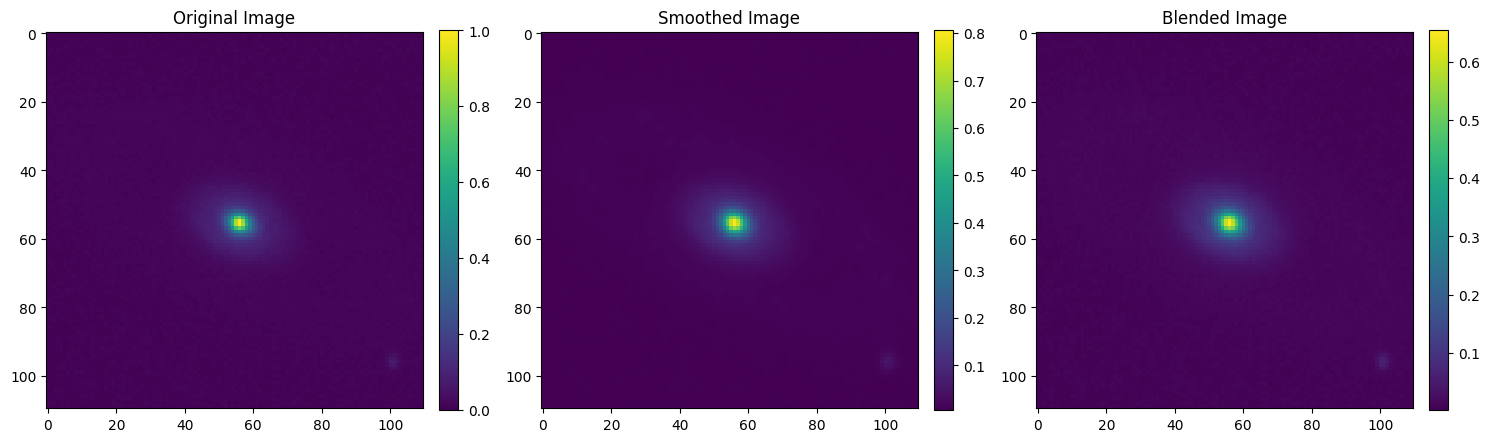

In [9]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage import exposure

def softening_image(image, sigma=None, alpha=None, gamma=None, contrast_stretch=True, show=True):
    """
    Creates a high-quality softened galaxy image by blending the original and smoothed images
    with optional contrast enhancement that preserves features.
    
    Parameters:
    - image : 2D numpy array
        Input galaxy image.
    - sigma : float or None
        Standard deviation for Gaussian filter (None will calculate dynamically based on image properties).
    - alpha : float or None
        Blending factor between the original and smoothed image (None will calculate based on image properties).
    - gamma : float or None
        Gamma correction factor (None will calculate dynamically based on image intensity).
    - contrast_stretch : bool
        If True, applies contrast stretching to enhance features.
    - show : bool
        If True, displays the original, smoothed, and blended images.
    
    Returns:
    - blended_image : 2D numpy array
        The high-quality blended galaxy image.
    """
    # Normalize the input image
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Step 1: Dynamically calculate sigma if not provided
    if sigma is None:
        image_variance = np.var(image)
        if image_variance > 0.02:
            sigma = 2.0
        else:
            sigma = 1.0 

    # Step 2: Dynamically calculate alpha if not provided (based on the image contrast)
    if alpha is None:
        image_std = np.std(image)
        if image_std>0.2:
            alpha = 0.8
        else:
            alpha = 0.6
    
    # Step 3: Dynamically calculate gamma if not provided (based on the image brightness)
    if gamma is None:
        mean_intensity = np.mean(image)
        if mean_intensity<0.4:
            gamma = 1.0
        else:
            gamma = 0.5
    
    # Apply Gaussian smoothing
    smoothed_image = gaussian_filter(image, sigma=sigma)
    
    # Blend the original and smoothed images
    blended_image = alpha * image + (1 - alpha) * smoothed_image
    
    # Optional: Gamma correction for non-linear brightness adjustment
    blended_image = np.float_power(blended_image, gamma)

    if contrast_stretch:
        # Apply logarithmic stretch to enhance contrast without overblowing features
        blended_image = np.log1p(blended_image) 
        blended_image = np.clip(blended_image, 0, 1)  # Normalize back to [0, 1] range
    
    # Visualization
    if show:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        ax1, ax2, ax3 = axes
        
        im1 = ax1.imshow(image, cmap='viridis')
        ax1.set_title("Original Image")
        plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        
        im2 = ax2.imshow(smoothed_image, cmap='viridis')
        ax2.set_title("Smoothed Image")
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        
        im3 = ax3.imshow(blended_image, cmap='viridis')
        ax3.set_title("Blended Image")
        plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.show()
    
    return blended_image

# Example usage
# Replace 'cropped_image' with your actual galaxy data
high_quality_blended_image = softening_image(
    cropped_image, sigma=None, alpha=None, gamma=None, contrast_stretch=True, show=True
)


**Once the fetures of the galaxy's are softened and enhanced using contrast streching :**

We have to now build the *Convolutional Neural Network* to train the softened images to output the *Spectrum*

In [ ]:
from tensorflow import